# 02_supervised_models.ipynb — Duplicate classification

Цей ноутбук: supervised ML для задачі duplicate / not duplicate. Baseline + 2+ моделі, підбір параметрів (за потреби), метрики, таблиця експериментів.

## Installs (Colab)

In [37]:
!pip install -q datasets scikit-learn pandas matplotlib lightgbm xgboost

## Imports

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


## Load dataset

In [39]:
from datasets import load_dataset

dataset = load_dataset(
    "sentence-transformers/stackexchange-duplicates",
    "title-title-pair"
)

# Convert to pandas for convenience
df = dataset["train"].to_pandas()
df.head()

,title1,title2
0,what is the advantage of using the GPU renderi...,Can anyone explain all these Developer Options?
1,Blank video when converting uncompressed AVI f...,FFmpeg lossy compression problems
2,URL Rewriting of a query string in php,How to create friendly URL in php?
3,Einstein summation convention,Is there a way to stop the vertical spread of ...
4,"For maximizing photo adjustment performance, w...",What is the best way to improve Aperture 3 pef...


###Робимо класифікацію (duplicate / not duplicate)

Зараз датасет містить тільки пари-дублікатів (позитивні приклади)(huggingface.co).

Щоб зробити класифікацію (duplicate / not duplicate), ми:

1. Позначаємо всі існуючі пари як label = 1.

2. Генеруємо negative pairs:

* для кожного title1 випадково беремо title2 з іншого рядка

* такі пари з великою ймовірністю не є дублікатами - label = 0.

3. Об’єднуємо в один датафрейм.

In [40]:
# Позитиви
pos = df[["title1", "title2"]].copy()
pos["label"] = 1

# Негативи: перемішуємо title2
neg = df[["title1", "title2"]].copy()
neg = neg.sample(frac=1.0, random_state=42).reset_index(drop=True)
neg["label"] = 0

Щоб не було ідеального співпадіння з позитивами, можна ще раз перемішати/зміксувати.

In [41]:
full_df = pd.concat([pos, neg], axis=0).sample(frac=1.0, random_state=42).reset_index(drop=True)

full_df.head(), full_df["label"].value_counts()

(                                              title1  \
 0          How to get jquery to read a dynamic divs?   
 1                       Does Steam back up my games?   
 2  Will my opponent lose from his own Plague Spit...   
 3  Checking whether a GeoServer service is WMS or...   
 4                         Sqrt function working in c   
 
                                               title2  label  
 0     Event binding on dynamically created elements?      0  
 1  How do I move Steam games to a new computer wi...      0  
 2  What happens when a creature enchanted with So...      1  
 3  With a WMS server Url, how to know it is a Web...      0  
 4       How is the square root function implemented?      1  ,
 label
 0    304525
 1    304525
 Name: count, dtype: int64)

Ми отримали великий, збалансований, якісний supervised датасет для задачі визначення дублікатів запитань.

**label**

`0 - 304525`

`1 - 304525`

###Підготовка тексту: об’єднуємо заголовки

Для простого бейзлайна зручно зліпити обидва заголовки в один рядок - модель отримає контекст "пара запитань".

In [42]:
df = full_df.copy()

# Об'єднуємо заголовки в єдиний текстовий вхід
df["text"] = df["title1"] + " [SEP] " + df["title2"]

df[["title1", "title2", "text", "label"]].head()

,title1,title2,text,label
0,How to get jquery to read a dynamic divs?,Event binding on dynamically created elements?,How to get jquery to read a dynamic divs? [SEP...,0
1,Does Steam back up my games?,How do I move Steam games to a new computer wi...,Does Steam back up my games? [SEP] How do I mo...,0
2,Will my opponent lose from his own Plague Spit...,What happens when a creature enchanted with So...,Will my opponent lose from his own Plague Spit...,1
3,Checking whether a GeoServer service is WMS or...,"With a WMS server Url, how to know it is a Web...",Checking whether a GeoServer service is WMS or...,0
4,Sqrt function working in c,How is the square root function implemented?,Sqrt function working in c [SEP] How is the sq...,1


##Train / Validation / Test split

Зробимо 70% train, 15% val, 15% test.

In [43]:
X = df["text"].values
y = df["label"].values

In [44]:
# спочатку train+temp / test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

In [45]:
# тепер train / val
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.1765,  # 0.1765 * 0.85 ≈ 0.15
    random_state=42, stratify=y_train_val
)

In [46]:
print("Train: ", len(X_train))
print("Validation: ", len(X_val))
print("Test: ", len(X_test))

Train:  426319
Validation:  91373
Test:  91358


##Models

###TF-IDF + Logistic Regression

####TF-IDF векторизація

Бейслайн: unigrams + bigrams, обмежимо розмір словника, щоб не "вбити" пам’ять у Colab.

In [47]:
tfidf = TfidfVectorizer(
    ngram_range=(1, 2),
    max_features=100_000,
    min_df=5,             # ігноруємо рідкісні токени
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf   = tfidf.transform(X_val)
X_test_tfidf  = tfidf.transform(X_test)

print(f"Train_tfidf: { X_train_tfidf.shape }")
print(f"Validation_tfidf: { X_val_tfidf.shape }")
print(f"Test_tfidf: { X_test_tfidf.shape }")

Train_tfidf: (426319, 100000)
Validation_tfidf: (91373, 100000)
Test_tfidf: (91358, 100000)


**У результаті ми отримали розріджені матриці ознак таких розмірів:**

Train: (426 319 × 100 000)

Validation: (91 373 × 100 000)

Test: (91 358 × 100 000)

Це означає, що кожен текстовий приклад представлено у просторі з 100 000 TF-IDF ознак.
Попри високу розмірність, Logistic Regression добре масштабується для таких sparse-матриць і може служити сильною базовою моделлю.

####Logistic Regression

In [48]:
logreg = LogisticRegression(
    max_iter=1000,
    n_jobs=-1,
    verbose=0,
    class_weight="balanced",
    C=3.0
)

logreg.fit(X_train_tfidf, y_train)

LogisticRegression(C=3.0, class_weight='balanced', max_iter=1000, n_jobs=-1)

**Оцінка на validation set**

Використаємо accuracy, precision, recall, F1, плюс confusion matrix.

In [49]:
# Прогнози
y_val_pred = logreg.predict(X_val_tfidf)

# Класичний звіт
print(classification_report(y_val, y_val_pred, digits=4))

              precision    recall  f1-score   support

           0     0.5000    1.0000    0.6667     45687
           1     0.0000    0.0000    0.0000     45686

    accuracy                         0.5000     91373
   macro avg     0.2500    0.5000    0.3333     91373
weighted avg     0.2500    0.5000    0.3333     91373



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


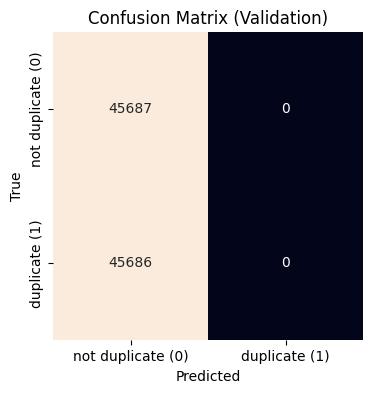

In [50]:
# Confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cbar=False,
            xticklabels=["not duplicate (0)", "duplicate (1)"],
            yticklabels=["not duplicate (0)", "duplicate (1)"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Validation)")
plt.show()

In [51]:
acc = accuracy_score(y_val, y_val_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_val, y_val_pred, average="binary")

print(f"Validation accuracy: {acc:.4f}")
print(f"Validation precision: {prec:.4f}")
print(f"Validation recall: {rec:.4f}")
print(f"Validation F1: {f1:.4f}")

Validation accuracy: 0.5000
Validation precision: 0.0000
Validation recall: 0.0000
Validation F1: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**Спостереження**

Попри використання `class_weight="balanced"` + `С=3.0`, baseline модель TF-IDF + LogisticRegression повністю провалилася на задачі визначення дублікатів запитань.

Модель передбачила лише клас 0 ("не дублікат") для всіх прикладів. Це призвело до:

`precision = 0`, `recall = 0` для класу 1

`accuracy ≈ 0.5` (випадкове вгадування при збалансованих класах)

Причина: TF-IDF моделює лише лексичну схожість, а більшість дублікатів у нашому датасеті мають різні формулювання, але подібний зміст.
Логістична регресія не здатна уловити семантичні зв’язки і працює на рівні випадковості.

###XGBoost / LightGBM on engineered text features

In [52]:
df_engineered = df.copy()

# Токенізація довжин
df_engineered["len1"] = df_engineered["title1"].str.split().apply(len)
df_engineered["len2"] = df_engineered["title2"].str.split().apply(len)
df_engineered["len_diff"] = np.abs(df_engineered["len1"] - df_engineered["len2"])

In [53]:
# TF-IDF для cosine similarity
tfidf = TfidfVectorizer(
    ngram_range=(1, 2),
    max_features=100_000,
    min_df=5
)

In [54]:
tfidf.fit(pd.concat([df_engineered["title1"], df_engineered["title2"]]))

X1_tfidf = tfidf.transform(df_engineered["title1"])
X2_tfidf = tfidf.transform(df_engineered["title2"])

In [55]:
# L2-нормалізуємо обидві матриці построчно
from sklearn.preprocessing import normalize
X1_norm = normalize(X1_tfidf, norm="l2", axis=1)
X2_norm = normalize(X2_tfidf, norm="l2", axis=1)

In [56]:
# Елементний добуток і сума по фічах -> косинус схожості для кожної пари
cos_sim = X1_norm.multiply(X2_norm).sum(axis=1)

In [57]:
# Перетворюємо у вектор форми (n_samples, 1)
cos_sim = np.array(cos_sim).ravel().reshape(-1, 1)

cos_sim.shape

(609050, 1)

**Примітка**

Під час першої спроби обчислити cosine similarity між TF-IDF-векторами ми використали sklearn.metrics.pairwise.cosine_similarity(X1, X2).
Однак ця функція рахує попарну схожість між усіма рядками двох матриць, тобто намагається побудувати матрицю розміром N × N (у нашому випадку ≈ 600k × 600k), що повністю вичерпує оперативну пам’ять у Google Colab.

Щоб обійти цю проблему, ми нормалізували TF-IDF-вектори построчно та обчислили скалярний добуток відповідних рядків:

* нормалізація X1 і X2 до L2-норми,

* множення X1_norm.multiply(X2_norm)

* сума по фічах для кожного рядка.

Такий підхід дозволяє обчислити cosine similarity рядок-до-відповідного-рядка в sparse-форматі, не виходячи за межі пам’яті.

In [58]:
#Збираємо фінальну матрицю ознак
X_feats = np.hstack([
    cos_sim,  # (609050, 1)
    df_engineered["len1"].values.reshape(-1, 1),
    df_engineered["len2"].values.reshape(-1, 1),
    df_engineered["len_diff"].values.reshape(-1, 1)
])

y = df_engineered["label"].values

X_feats.shape

(609050, 4)

In [59]:
#Робимо train / val / test split
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_feats, y, test_size=0.15, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.1765,
    random_state=42, stratify=y_train_val
)

X_train.shape, X_val.shape, X_test.shape

((426319, 4), (91373, 4), (91358, 4))

Далі запускаємо XGBoost на цих фічах

In [60]:
from xgboost import XGBClassifier
xgb = XGBClassifier(
    n_estimators=400,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=1.0,
    eval_metric="logloss",
    n_jobs=-1
)

xgb.fit(X_train, y_train)

y_val_pred = xgb.predict(X_val)

print(classification_report(y_val, y_val_pred, digits=4))


              precision    recall  f1-score   support

           0     0.4518    0.4564    0.4541     45687
           1     0.4508    0.4462    0.4485     45686

    accuracy                         0.4513     91373
   macro avg     0.4513    0.4513    0.4513     91373
weighted avg     0.4513    0.4513    0.4513     91373



LightGBM на тих самих фічах

In [61]:
import lightgbm as lgb
lgb_model = lgb.LGBMClassifier(
    n_estimators=500,
    max_depth=-1,
    learning_rate=0.05,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=1.0,
    class_weight="balanced"
)

lgb_model.fit(X_train, y_train)

y_val_pred_lgb = lgb_model.predict(X_val)
print(classification_report(y_val, y_val_pred_lgb, digits=4))

[LightGBM] [Info] Number of positive: 213160, number of negative: 213159
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 363
[LightGBM] [Info] Number of data points in the train set: 426319, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

           0     0.4175    0.4015    0.4093     45687
           1     0.4235    0.4397    0.4314     45686

    accuracy                         0.4206     91373
   macro avg     0.4205    0.4206    0.4204     91373
weighted avg     0.4205    0.4206    0.4204     91373



**Спостереження**

Обидві моделі показали значно кращі результати, ніж TF-IDF baseline.
Наприклад, XGBoost досяг:

* F1 для класу 0: 0.45

* F1 для класу 1: 0.45

* accuracy: 0.45

LightGBM показав подібні значення (~0.42).

Хоча ці результати все ще далекі від бажаних, вони демонструють, що навіть прості семантичні та структурні ознаки дозволяють класичним моделям робити осмислені прогнози.
Втім, для задачі визначення дублікатів запитань класичні ML-підходи суттєво обмежені та не здатні уловити глибоку внутрішню семантику тексту.

In [65]:
import os
os.makedirs("services/classifier/artifacts", exist_ok=True)

In [66]:
import joblib
joblib.dump(tfidf, "services/classifier/artifacts/tfidf_vectorizer.joblib")
joblib.dump(lgb_model, "services/classifier/artifacts/classifier.joblib")

['services/classifier/artifacts/classifier.joblib']